In [ ]:
import importlib
import subprocess
import sys


packages = ['torch', 'torchvision', 'torch-rs', 'timm', 'fvcore']


for package in packages:
  try:
      importlib.import_module(package)
  except ImportError:
      print(f"Installing {package}...")
      subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  else:
      print(f"{package} is already installed.")


torch is already installed.
torchvision is already installed.
Installing torch-rs...
timm is already installed.
fvcore is already installed.


# Data Augmentation
| **Methodology**            | **Probability** | **Setting**                        | **Value**  |
|----------------------------|-----------------|------------------------------------|------------|
| **Color Jitter**           |       0.7       | Brightness & Contrast & Saturation |     0.5    |
| **Random Horizontal Flip** |       0.9       |               Default              |   Default  |
| **Random Vertical Flip**   |       0.9       |               Default              |   Default  |
| **Random Rotation**        |       0.3       |               Degrees              | (-180,180) |
| **Random Grayscale**       |       0.1       |               Default              |   Default  |
| **Random Auto Contrast**   |       0.1       |               Default              |   Default  |
| **Random Erasing**         |       1.0       |               Default              |   Default  |
| **Random Resize Crop**     |       0.1       |                Size                |     192    |
| **CutMix**                 |       1.0       |               Default              |   Default  |


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the data augmentation transformations
data_transforms_train = transforms.Compose([
    # Colour Jitter (Brightness, Contrast, Saturation) with probability of 0.7
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)], p=0.7),

    # Random Horizontal Flip with probability of 0.9
    transforms.RandomHorizontalFlip(p=0.9),

    # Random Vertical Flip with probability of 0.9
    transforms.RandomVerticalFlip(p=0.9),

    # Random Rotation between -180 to 180 degrees with probability of 0.9
    transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.3),

    # Random Grayscale with probability of 0.1
    transforms.RandomGrayscale(p=0.1),

    # Random Auto Contrast with probability of 1.0
    transforms.RandomAutocontrast(p=1.0),

    # Random Erasing with probability of 0.1
    transforms.RandomErasing(p=0.1),

    # Random Resized Crop to 192x192 with probability of 0.1
    transforms.RandomApply([transforms.RandomResizedCrop(size=192)], p=0.1),

    # Convert to Tensor
    transforms.ToTensor(),
])

# Define the data transformation for testing (without augmentation)
data_transforms_test = transforms.Compose([
    transforms.ToTensor(),
])


In [ ]:
from google.colab import drive
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

# Load and split the dataset using few shot learing with a Training ratio of 10-90

In [ ]:
from torchrs.datasets import RESISC45
from torch.utils.data import random_split
from torchvision.transforms import v2

# link to dataset https://drive.google.com/drive/folders/1q7Rar-Pu1ygShd5ly16sXsjVthKWOVHT?usp=share_link
resisc45 = RESISC45(
    root="/content/drive/MyDrive/COMP 841/Datasets/NWPU-RESISC45",
    transform=None
)

full_dataset = resisc45

class_names = full_dataset.classes
num_classes = len(class_names)
resolution = 256
batch_size=32

# Calculate the lengths of the train and test splits
train_split = 0.1
train_size = int(train_split * len(full_dataset))  # 10% for training
test_size = len(full_dataset) - train_size  # 90% for testing

# Split the dataset into training and testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply the training transformation to the train dataset
train_dataset.dataset.transform = data_transforms_train

# # Apply the test transformation to the test dataset
test_dataset.dataset.transform = data_transforms_test

# Create DataLoader for training
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,  # Adjust the batch size
    shuffle=True,
    num_workers=4  # Adjust based on your system
)

# Create DataLoader for testing
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

# CutMix datatransformation to be applied during time of trsting

In [ ]:
from torch.utils.data import default_collate

# Define cutmix
cutmix = v2.CutMix(num_classes=num_classes)

# Apply CutMix with a probability (e.g., 50%)
def apply_cutmix(images, labels, prob=1.0, versbose=False):
    if torch.rand(1) < prob:
      if versbose:
        print(f"Before CutMix: {images.shape = }, {labels.shape = }")
      images, labels = cutmix(images, labels)
      if versbose:
        print(f"After CutMix: {images.shape = }, {labels.shape = }")
    return images, labels

train_loader.collate_fn = lambda batch: (apply_cutmix(*default_collate(batch)))

# Adaptive Token as defined by [A-ViT: Adaptive Tokens for Efficient Vision Transformer](https://openaccess.thecvf.com/content/CVPR2022/papers/Yin_A-ViT_Adaptive_Tokens_for_Efficient_Vision_Transformer_CVPR_2022_paper.pdf)

In [ ]:
from torch import nn

class AdaptiveTokenSelector(nn.Module):
    """
    Selects a subset of tokens based on learned importance scores.
    """
    def __init__(self, dim, keep_ratio=0.75):
        super().__init__()
        self.keep_ratio = keep_ratio
        self.score_proj = nn.Linear(dim, 1)

    def forward(self, x):
        # x: [B, N, C]
        scores = self.score_proj(x).squeeze(-1)  # [B, N]
        num_keep = max(1, int(self.keep_ratio * x.shape[1]))  # avoid 0 tokens
        topk_scores, topk_indices = scores.topk(num_keep, dim=1, sorted=False)  # [B, num_keep]

        # Gather top-k tokens
        batch_indices = torch.arange(x.size(0), device=x.device).unsqueeze(-1)
        selected_tokens = x[batch_indices, topk_indices]  # [B, num_keep, C]
        return selected_tokens

# [Next ViT source code](https://github.com/bytedance/Next-ViT)

In [ ]:
# Copyright (c) ByteDance Inc. All rights reserved.
from functools import partial

import torch
import torch.utils.checkpoint as checkpoint
from einops import rearrange, reduce
from timm.layers import DropPath, trunc_normal_
from timm.models import register_model
from torch import nn

NORM_EPS = 1e-5

def merge_pre_bn(module, pre_bn_1, pre_bn_2=None):
    """ Merge pre BN to reduce inference runtime.
    """
    weight = module.weight.data
    if module.bias is None:
        zeros = torch.zeros(module.out_channels, device=weight.device).type(weight.type())
        module.bias = nn.Parameter(zeros)
    bias = module.bias.data
    if pre_bn_2 is None:
        assert pre_bn_1.track_running_stats is True, "Unsupport bn_module.track_running_stats is False"
        assert pre_bn_1.affine is True, "Unsupport bn_module.affine is False"

        scale_invstd = pre_bn_1.running_var.add(pre_bn_1.eps).pow(-0.5)
        extra_weight = scale_invstd * pre_bn_1.weight
        extra_bias = pre_bn_1.bias - pre_bn_1.weight * pre_bn_1.running_mean * scale_invstd
    else:
        assert pre_bn_1.track_running_stats is True, "Unsupport bn_module.track_running_stats is False"
        assert pre_bn_1.affine is True, "Unsupport bn_module.affine is False"

        assert pre_bn_2.track_running_stats is True, "Unsupport bn_module.track_running_stats is False"
        assert pre_bn_2.affine is True, "Unsupport bn_module.affine is False"

        scale_invstd_1 = pre_bn_1.running_var.add(pre_bn_1.eps).pow(-0.5)
        scale_invstd_2 = pre_bn_2.running_var.add(pre_bn_2.eps).pow(-0.5)

        extra_weight = scale_invstd_1 * pre_bn_1.weight * scale_invstd_2 * pre_bn_2.weight
        extra_bias = scale_invstd_2 * pre_bn_2.weight *(pre_bn_1.bias - pre_bn_1.weight * pre_bn_1.running_mean * scale_invstd_1 - pre_bn_2.running_mean) + pre_bn_2.bias

    if isinstance(module, nn.Linear):
        extra_bias = weight @ extra_bias
        weight.mul_(extra_weight.view(1, weight.size(1)).expand_as(weight))
    elif isinstance(module, nn.Conv2d):
        assert weight.shape[2] == 1 and weight.shape[3] == 1
        weight = weight.reshape(weight.shape[0], weight.shape[1])
        extra_bias = weight @ extra_bias
        weight.mul_(extra_weight.view(1, weight.size(1)).expand_as(weight))
        weight = weight.reshape(weight.shape[0], weight.shape[1], 1, 1)
    bias.add_(extra_bias)

    module.weight.data = weight
    module.bias.data = bias


class ConvBNReLU(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            groups=1):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                              padding=1, groups=groups, bias=False)
        self.norm = nn.BatchNorm2d(out_channels, eps=NORM_EPS)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class PatchEmbed(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1):
        super(PatchEmbed, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        if stride == 2:
            self.avgpool = nn.AvgPool2d((2, 2), stride=2, ceil_mode=True, count_include_pad=False)
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        elif in_channels != out_channels:
            self.avgpool = nn.Identity()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        else:
            self.avgpool = nn.Identity()
            self.conv = nn.Identity()
            self.norm = nn.Identity()

    def forward(self, x):
        return self.norm(self.conv(self.avgpool(x)))


class MHCA(nn.Module):
    """
    Multi-Head Convolutional Attention
    """
    def __init__(self, out_channels, head_dim):
        super(MHCA, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        self.group_conv3x3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                                       padding=1, groups=out_channels // head_dim, bias=False)
        self.norm = norm_layer(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.projection = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.group_conv3x3(x)
        out = self.norm(out)
        out = self.act(out)
        out = self.projection(out)
        return out


class Mlp(nn.Module):
    def __init__(self, in_features, out_features=None, mlp_ratio=None, drop=0., bias=True):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = _make_divisible(in_features * mlp_ratio, 32)
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=1, bias=bias)
        self.act = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(hidden_dim, out_features, kernel_size=1, bias=bias)
        self.drop = nn.Dropout(drop)

    def merge_bn(self, pre_norm):
        merge_pre_bn(self.conv1, pre_norm)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        return x


class NCB(nn.Module):
    """
    Next Convolution Block
    """
    def __init__(self, in_channels, out_channels, stride=1, path_dropout=0,
                 drop=0, head_dim=32, mlp_ratio=3):
        super(NCB, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        assert out_channels % head_dim == 0

        self.patch_embed = PatchEmbed(in_channels, out_channels, stride)
        self.mhca = MHCA(out_channels, head_dim)
        self.attention_path_dropout = DropPath(path_dropout)

        self.norm = norm_layer(out_channels)
        self.mlp = Mlp(out_channels, mlp_ratio=mlp_ratio, drop=drop, bias=True)
        self.mlp_path_dropout = DropPath(path_dropout)
        self.is_bn_merged = False

    def merge_bn(self):
        if not self.is_bn_merged:
            self.mlp.merge_bn(self.norm)
            self.is_bn_merged = True

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.attention_path_dropout(self.mhca(x))
        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm(x)
        else:
            out = x
        x = x + self.mlp_path_dropout(self.mlp(out))
        return x


class E_MHSA(nn.Module):
    """
    Efficient Multi-Head Self Attention
    """
    def __init__(self, dim, out_dim=None, head_dim=32, qkv_bias=True, qk_scale=None,
                 attn_drop=0, proj_drop=0., sr_ratio=1, keep_ratio=1.0):
        super().__init__()
        self.dim = dim
        self.out_dim = out_dim if out_dim is not None else dim
        self.num_heads = self.dim // head_dim
        self.scale = qk_scale or head_dim ** -0.5
        self.q = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.k = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.v = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.proj = nn.Linear(self.dim, self.out_dim)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        # A-ViT paramaters ----------
        self.keep_ratio = keep_ratio
        if self.keep_ratio < 1.0:
          self.adaptive_selector = AdaptiveTokenSelector(dim, keep_ratio=self.keep_ratio)
        # ---------------------------
        self.sr_ratio = sr_ratio
        self.N_ratio = sr_ratio ** 2
        if sr_ratio > 1:
            self.sr = nn.AvgPool1d(kernel_size=self.N_ratio, stride=self.N_ratio)
            self.norm = nn.BatchNorm1d(dim, eps=NORM_EPS)
        self.is_bn_merged = False

    def merge_bn(self, pre_bn):
        merge_pre_bn(self.q, pre_bn)
        if self.sr_ratio > 1:
            merge_pre_bn(self.k, pre_bn, self.norm)
            merge_pre_bn(self.v, pre_bn, self.norm)
        else:
            merge_pre_bn(self.k, pre_bn)
            merge_pre_bn(self.v, pre_bn)
        self.is_bn_merged = True

    def forward(self, x):
        B, N, C = x.shape

        # --- Adaptive token selection ---
        if self.keep_ratio < 1.0:
            x = self.adaptive_selector(x)
            N = x.shape[1]
        # ---------------------------------


        q = self.q(x)
        q = q.reshape(B, N, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.transpose(1, 2)

            # Skip pooling if N < kernel size due to adaptive token selection
            if x_.shape[2] >= self.N_ratio:
                x_ = self.sr(x_)
            else:
                x_ = x_

            if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
                x_ = self.norm(x_)
            x_ = x_.transpose(1, 2)
            k = self.k(x_)
            k = k.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 3, 1)
            v = self.v(x_)
            v = v.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)
        else:
            k = self.k(x)
            k = k.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 3, 1)
            v = self.v(x)
            v = v.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)
        attn = (q @ k) * self.scale

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class NTB(nn.Module):
    """
    Next Transformer Block
    """
    def __init__(
            self, in_channels, out_channels, path_dropout, stride=1, sr_ratio=1,
            mlp_ratio=2, head_dim=32, mix_block_ratio=0.75, attn_drop=0, drop=0,
            keep_ratio=1.0, preserve_spational_layout=False,
    ):
        super(NTB, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mix_block_ratio = mix_block_ratio
        norm_func = partial(nn.BatchNorm2d, eps=NORM_EPS)

        self.mhsa_out_channels = _make_divisible(int(out_channels * mix_block_ratio), 32)
        self.mhca_out_channels = out_channels - self.mhsa_out_channels

        self.patch_embed = PatchEmbed(in_channels, self.mhsa_out_channels, stride)
        self.norm1 = norm_func(self.mhsa_out_channels)

        # Adaptive-Vit --------
        self.preserve_spational_layout = preserve_spational_layout
        self.e_mhsa = E_MHSA(self.mhsa_out_channels, head_dim=head_dim, sr_ratio=sr_ratio,
                             attn_drop=attn_drop, proj_drop=drop, keep_ratio=keep_ratio)
        #----------------------

        self.mhsa_path_dropout = DropPath(path_dropout * mix_block_ratio)

        self.projection = PatchEmbed(self.mhsa_out_channels, self.mhca_out_channels, stride=1)
        self.mhca = MHCA(self.mhca_out_channels, head_dim=head_dim)
        self.mhca_path_dropout = DropPath(path_dropout * (1 - mix_block_ratio))

        self.norm2 = norm_func(out_channels)
        self.mlp = Mlp(out_channels, mlp_ratio=mlp_ratio, drop=drop)
        self.mlp_path_dropout = DropPath(path_dropout)

        self.is_bn_merged = False

    def merge_bn(self):
        if not self.is_bn_merged:
            self.e_mhsa.merge_bn(self.norm1)
            self.mlp.merge_bn(self.norm2)
            self.is_bn_merged = True

    def forward(self, x):
        x = self.patch_embed(x)
        B, C, H, W = x.shape
        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm1(x)
        else:
            out = x
        out = rearrange(out, "b c h w -> b (h w) c")  # b n c
        out = self.mhsa_path_dropout(self.e_mhsa(out))

        # A-ViT -------------------
        if self.e_mhsa.keep_ratio < 1.0:
          if self.preserve_spational_layout:
            out_reshaped = rearrange(out, "b n c -> b c 1 n")  # flat feature
            out_upsampled = torch.nn.functional.interpolate(out_reshaped, size=H*W, mode="nearest")
            x = x + rearrange(out_upsampled, "b c 1 (h_w) -> b c h w", h=H)
          else:
            out = rearrange(out, "b n c -> b c n")
            out = reduce(out, "b c n -> b c 1 1", "mean")
            x = out
        else:
            x = x + rearrange(out, "b (h w) c -> b c h w", h=H)
        # --------------------------

        out = self.projection(x)
        out = out + self.mhca_path_dropout(self.mhca(out))
        x = torch.cat([x, out], dim=1)

        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm2(x)
        else:
            out = x
        x = x + self.mlp_path_dropout(self.mlp(out))
        return x


class NextViT(nn.Module):
    def __init__(self, stem_chs, depths, path_dropout, attn_drop=0, drop=0, num_classes=1000,
                  strides=[1, 2, 2, 2], sr_ratios=[8, 4, 2, 1], head_dim=32, mix_block_ratio=0.75,
                  use_checkpoint=False, keep_ratios=1.0, preserve_spatial_layout=False):
        super(NextViT, self).__init__()
        self.use_checkpoint = use_checkpoint

        self.stage_out_channels = [[96] * (depths[0]),
                                    [192] * (depths[1] - 1) + [256],
                                    [384, 384, 384, 384, 512] * (depths[2] // 5),
                                    [768] * (depths[3] - 1) + [1024]]

        self.stage_block_types = [[NCB] * depths[0],
                                  [NCB] * (depths[1] - 1) + [NTB],
                                  [NCB, NCB, NCB, NCB, NTB] * (depths[2] // 5),
                                  [NCB] * (depths[3] - 1) + [NTB]]

        self.stem = nn.Sequential(
            ConvBNReLU(3, stem_chs[0], kernel_size=3, stride=2),
            ConvBNReLU(stem_chs[0], stem_chs[1], kernel_size=3, stride=1),
            ConvBNReLU(stem_chs[1], stem_chs[2], kernel_size=3, stride=1),
            ConvBNReLU(stem_chs[2], stem_chs[2], kernel_size=3, stride=2),
        )
        input_channel = stem_chs[-1]
        features = []
        idx = 0
        dpr = [x.item() for x in torch.linspace(0, path_dropout, sum(depths))]

        # Allow keep_ratios to be list for per-layer pruning
        if isinstance(keep_ratios, (float, int)):
            keep_ratios = [keep_ratios] * sum(depths)
        assert len(keep_ratios) == sum(depths), "Length of keep_ratios must match total number of blocks"

        for stage_id in range(len(depths)):
            numrepeat = depths[stage_id]
            output_channels = self.stage_out_channels[stage_id]
            block_types = self.stage_block_types[stage_id]
            for block_id in range(numrepeat):
                if strides[stage_id] == 2 and block_id == 0:
                    stride = 2
                else:
                    stride = 1
                output_channel = output_channels[block_id]
                block_type = block_types[block_id]
                keep_ratio = keep_ratios[stage_id]

                if block_type is NCB:
                    layer = NCB(input_channel, output_channel, stride=stride,
                                path_dropout=dpr[stage_id], drop=drop, head_dim=head_dim)
                elif block_type is NTB:
                    layer = NTB(input_channel, output_channel, path_dropout=dpr[stage_id], stride=stride,
                                sr_ratio=sr_ratios[stage_id], head_dim=head_dim, mix_block_ratio=mix_block_ratio,
                                attn_drop=attn_drop, drop=drop,
                                keep_ratio=keep_ratios[stage_id], preserve_spational_layout=preserve_spatial_layout)
                features.append(layer)
                input_channel = output_channel

        self.features = nn.Sequential(*features)
        self.norm = nn.BatchNorm2d(output_channel, eps=NORM_EPS)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj_head = nn.Sequential(nn.Linear(output_channel, num_classes))
        self.stage_out_idx = [sum(depths[:idx + 1]) - 1 for idx in range(len(depths))]

        print('initialize_weights...')
        self._initialize_weights()

    def merge_bn(self):
        self.eval()
        for idx, module in self.named_modules():
            if isinstance(module, NCB) or isinstance(module, NTB):
                module.merge_bn()

    def _initialize_weights(self):
        for n, m in self.named_modules():
            if isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        for idx, layer in enumerate(self.features):
            if self.use_checkpoint:
                x = checkpoint.checkpoint(layer, x)
            else:
                x = layer(x)
        x = self.norm(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.proj_head(x)
        return x


def nextvit_small(pretrained=False, pretrained_cfg=None, **kwargs):
    model = NextViT(stem_chs=[64, 32, 64], depths=[3, 4, 10, 3], path_dropout=0.1, **kwargs)
    return model


def nextvit_base(pretrained=False, pretrained_cfg=None, **kwargs):
    model = NextViT(stem_chs=[64, 32, 64], depths=[3, 4, 20, 3], path_dropout=0.2, **kwargs)
    return model


def nextvit_large(pretrained=False, pretrained_cfg=None, **kwargs):
    model = NextViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2, **kwargs)
    return model

In [ ]:
#ensemble Model
class EnsembleModel(nn.Module):
    def __init__(self, nextvit_model, efficientnet_model, w_e=0.5, num_classes=1000, teacher=False, resolution=192, batch_size=32, lp_size=1024,):
        super(EnsembleModel, self).__init__()
        self.nextvit = nextvit_model
        self.efficientnet = efficientnet_model
        self.w_e = w_e
        self.num_classes = num_classes

        dummy_input = torch.randn(batch_size, 3, resolution, resolution)  # Example input size

        # print(nextvit_model(dummy_input).shape)
        batch_size, num_nvit_features = nextvit_model(dummy_input).flatten(start_dim=1).shape
        batch_size, num_efficient_features = efficientnet_model(dummy_input).shape
        # print(num_nvit_features, num_efficient_features)

        # Add a linear layer to map both models' outputs to the same dimension (e.g., 1024)
        self.nextvit_fc = nn.Linear(num_nvit_features, lp_size)  # Example target size
        self.efficientnet_fc = nn.Linear(num_efficient_features, lp_size)  # Example target size

        self.fc = nn.Linear(lp_size * 2, num_classes)  # Output layer

    def forward(self, x):
        # Get the outputs from both models
        # print(f"x.shape = {x.shape}")
        p_nextvit = self.nextvit(x)  # Output logits from NextViT
        p_efficientnet = self.efficientnet(x) # Output logits from EfficientNet
        # print(f"nvit.shape = {p_nextvit.shape}")
        p_nextvit = self.nextvit_fc(p_nextvit.flatten(start_dim=1))  # Output logits from NextViT
        p_efficientnet = self.efficientnet_fc(p_efficientnet)  # Output logits from EfficientNet

        # Combine the outputs using the weight W_E
        p_t = (1 - self.w_e) * p_nextvit + self.w_e * p_efficientnet

        return torch.softmax(p_t, dim=1)

# Istantiate the ensemble teacher model comprised of a NViT and an EfficentNetB3

In [ ]:
from timm import create_model  # To load the NextViT model

#Load pre-trained models
nextvit_model = create_model('nextvit_small', pretrained=False, num_classes=num_classes)  # Example: NextViT model
efficientnet_model = create_model('efficientnet_b3', pretrained=False, num_classes=num_classes)  # Example: EfficientNet-B3 model

efficientnet_model.classifier = nn.Identity()  # Remove the final classifier layer from EfficientNet to output raw logits
nextvit_model.head = nn.Identity()  # Remove the final classifier layer from NextViT to output raw logits

# Create ensemble model
ensemble_model = EnsembleModel(nextvit_model, efficientnet_model, w_e=0.52, resolution=resolution, num_classes=num_classes)

In [ ]:
import time
import numpy as np
import torch
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_loader, device, class_names=None, per_sample=True, verbose=False):
    """
    Evaluate a model and return accuracy, average inference time (ms), std deviation (ms), FLOPs,
    and generate a confusion matrix.

    Parameters:
      model (torch.nn.Module): Trained PyTorch model.
      test_loader (DataLoader): DataLoader for test dataset.
      device (torch.device): Device to run the evaluation on.
      class_names (list): List of class names for the confusion matrix labels.
      verbose (bool): Whether to print inference time per image or batch.
      per_sample (bool): If True, report per-image timings. If False, report per-batch.
      display_confusion (bool): Whether to display the confusion matrix.

    Returns:
    Tuple[float, float, float, float, np.ndarray]:
        test_accuracy (%),
        avg_inference_time_ms,
        std_inference_time_ms,
        flops_per_image,
        confusion_mat
    """
    print("Beginning testing")
    model.eval()
    correct = 0
    total = 0
    inference_times = []
    flops_per_image = -1  # fallback

    # For confusion matrix
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)

            # Compute FLOPs once on first batch
            if i == 0:
                try:
                    flops = FlopCountAnalysis(model, images)
                    flops_per_image = flops.total() / batch_size
                    print(f"FLOPs per image: {flops_per_image / 1e6:.2f} MFLOPs")
                except Exception as e:
                    print("⚠️ FLOP analysis failed:", e)

            # Measure inference time
            start_time = time.perf_counter()
            outputs = model(images)
            end_time = time.perf_counter()
            elapsed = end_time - start_time  # seconds

            if per_sample:
                per_image_time = elapsed / batch_size * 1000  # convert to ms
                inference_times.extend([per_image_time] * batch_size)
                if verbose:
                    for j in range(batch_size):
                        img_idx = total + j
                        print(f"Inference time for image {img_idx}: {per_image_time:.3f} ms")
            else:
                elapsed_ms = elapsed * 1000
                inference_times.append(elapsed_ms)
                if verbose:
                    print(f"Inference time for batch {i}: {elapsed_ms:.3f} ms")

            _, predicted = torch.max(outputs, 1)

            # Store predictions and labels for confusion matrix
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics
    test_accuracy = 100 * correct / total
    avg_inference_time_ms = np.mean(inference_times)
    std_inference_time_ms = np.std(inference_times)
    unit = "Image" if per_sample else "Batch"

    # Generate confusion matrix
    conf_mat = confusion_matrix(all_labels, all_predicted)

    # Print metrics
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Average Inference Time per {unit}: {avg_inference_time_ms:.3f} ms")
    print(f"Std Dev of Inference Time per {unit}: {std_inference_time_ms:.3f} ms")
    if flops_per_image > 0:
        print(f"Estimated FLOPs per Image: {flops_per_image / 1e6:.2f} MFLOPs")

    return test_accuracy, avg_inference_time_ms, std_inference_time_ms, flops_per_image, conf_mat

def display_confusion_matrix(conf_mat, class_names):
    plt.figure(figsize=(10, 8))

    # If we have class names, use them for labels
    if class_names is not None:
        # Ensure we have the right number of class names
        if len(class_names) == conf_mat.shape[0]:
            sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_names, yticklabels=class_names)
        else:
            print(f"Warning: Number of class names ({len(class_names)}) doesn't match confusion matrix dimensions ({conf_mat.shape[0]})")
            sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    else:
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


In [ ]:
model = ensemble_model

# Check if CUDA is available and move the model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the model summary (commenting this out as it might contribute to memory issues)
summary(model, input_size=(3, resolution, resolution))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
       ConvNormAct-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]          18,432
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
       ConvNormAct-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,432
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
      ConvNormAct-12         [-1, 64, 128, 128]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

# Train and save the ensemble model

Beginning training

Epoch 1/600
 Step 50/99 - Loss: 6.8225
Epoch [1/600], Loss: 6.8470, Accuracy: 10.57%

Epoch 2/600
 Step 50/99 - Loss: 6.8625
Epoch [2/600], Loss: 6.8310, Accuracy: 10.16%

Epoch 3/600
 Step 50/99 - Loss: 6.8629
Epoch [3/600], Loss: 6.8110, Accuracy: 12.47%

Epoch 4/600
 Step 50/99 - Loss: 6.8416
Epoch [4/600], Loss: 6.7893, Accuracy: 14.54%

Epoch 5/600
 Step 50/99 - Loss: 6.6602
Epoch [5/600], Loss: 6.7858, Accuracy: 14.95%

Epoch 6/600
 Step 50/99 - Loss: 6.8656
Epoch [6/600], Loss: 6.7814, Accuracy: 15.39%

Epoch 7/600
 Step 50/99 - Loss: 6.7760
Epoch [7/600], Loss: 6.7734, Accuracy: 16.03%

Epoch 8/600
 Step 50/99 - Loss: 6.8072
Epoch [8/600], Loss: 6.7718, Accuracy: 16.34%

Epoch 9/600
 Step 50/99 - Loss: 6.7827
Epoch [9/600], Loss: 6.7847, Accuracy: 15.14%

Epoch 10/600
 Step 50/99 - Loss: 6.8170
Epoch [10/600], Loss: 6.7695, Accuracy: 16.53%

Epoch 11/600
 Step 50/99 - Loss: 6.8561
Epoch [11/600], Loss: 6.7575, Accuracy: 17.71%

Epoch 12/600
 Step 50/99 - Los

fc, nextvit.stages.0.blocks.0.attn_drop_path, nextvit.stages.0.blocks.0.mlp_drop_path, nextvit.stages.0.blocks.1.attn_drop_path, nextvit.stages.0.blocks.1.mlp_drop_path, nextvit.stages.0.blocks.1.patch_embed, nextvit.stages.0.blocks.2.attn_drop_path, nextvit.stages.0.blocks.2.mlp_drop_path, nextvit.stages.0.blocks.2.patch_embed, nextvit.stages.1.blocks.0.attn_drop_path, nextvit.stages.1.blocks.0.mlp_drop_path, nextvit.stages.1.blocks.1.attn_drop_path, nextvit.stages.1.blocks.1.mlp_drop_path, nextvit.stages.1.blocks.1.patch_embed, nextvit.stages.1.blocks.2.attn_drop_path, nextvit.stages.1.blocks.2.mlp_drop_path, nextvit.stages.1.blocks.2.patch_embed, nextvit.stages.1.blocks.3.e_mhsa.attn_drop, nextvit.stages.1.blocks.3.mhca_drop_path, nextvit.stages.1.blocks.3.mhsa_drop_path, nextvit.stages.1.blocks.3.mlp_drop_path, nextvit.stages.1.blocks.3.patch_embed, nextvit.stages.2.blocks.0.attn_drop_path, nextvit.stages.2.blocks.0.mlp_drop_path, nextvit.stages.2.blocks.1.attn_drop_path, nextvit.s

FLOPs per image: 8902.04 MFLOPs
Test Accuracy: 37.99%
Average Inference Time per Image: 1.079 ms
Std Dev of Inference Time per Image: 0.257 ms
Estimated FLOPs per Image: 8902.04 MFLOPs
Accuracy: 37.99%, Average Inference Time: 1.0791 ms, Std Dev: 0.2565 ms, FLOPs: 8902038592.0000


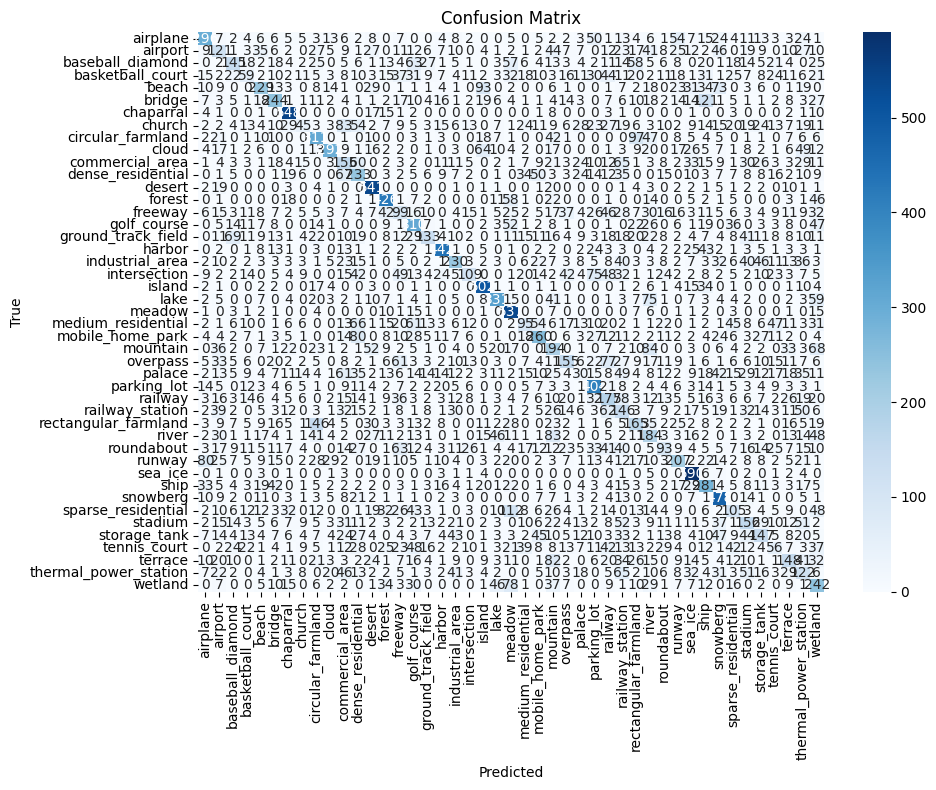

In [ ]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from datetime import datetime

# Initialize the model
model = ensemble_model

# Check if CUDA is available and move the model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the model summary (commenting this out as it might contribute to memory issues)
summary(model, input_size=(3, resolution, resolution))

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
print("Beginning training")
num_epochs = 600
epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()  # Set the model to training mode
    losses = []
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader, 1):
        # Clear cache before processing batch
        # torch.cuda.empty_cache()

        # Make sure to move data to device first
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        try:
            # Forward pass with gradient computation
            outputs = model(images)

            _, labels = torch.max(labels, 1)  # Convert one-hot to class indices
            loss = criterion(outputs, labels)

            # Calculate accuracy for hard labels
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total += images.size(0)
            losses.append(loss.item())

        except RuntimeError as e:
            print(f"Error during forward/backward pass: {e}")
            # Skip this batch if there's an error
            continue

        if i % 50 == 0:  # Print every 50 mini-batches
            print(f" Step {i}/{len(train_loader)} - Loss: {loss.item():.4f}")

    train_accuracy = 100 * correct / total
    epoch_losses.append(np.mean(losses))
    epoch_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4f}, Accuracy: {train_accuracy:.2f}%")

print("Saving model")
# Save Model
teacher_path = "/content/drive/MyDrive/COMP 841/Models/ensemble-model.pth"
torch.save(model.state_dict(), teacher_path)

# Evaluate the teacher model
acc, avg_ms, std_ms, flops, cf_matrix = evaluate_model(model, test_loader, device, verbose=False)
print(f"Accuracy: {acc:.2f}%, Average Inference Time: {avg_ms:.4f} ms, Std Dev: {std_ms:.4f} ms, FLOPs: {flops:.4f}")

# Define configuration parameters
params = {
    'resolution': resolution,
    'batch_size': batch_size,
    'train_split': train_split,
    'keep_ratios': 'Ensemble Teacher'
}

# Results dictionary without the `train_loss`
results = {
    'config': params,
    'accuracies': epoch_accuracies,
    'losses': epoch_losses,  # Keep losses
    'train_loss': np.mean(epoch_losses),  # Use the average loss from the last epoch
    'train_accuracy': epoch_accuracies[-1],  # Use the accuracy from the last epoch
    'accuracy': acc,
    'avg_ms': avg_ms,
    'std_ms': std_ms,
    'flops': flops
}

# Save results to a JSON file (without formatting the filename)
json.dump(results, open(f'/content/drive/MyDrive/COMP 841/Results/teacher-{datetime.now()}.json', 'w'))

# Display confusion matrix (assuming this function is defined elsewhere)
display_confusion_matrix(cf_matrix, class_names)


# [DIST Loss function](https://github.com/hunto/DIST_KD/blob/main/segmentation/losses/dist_kd.py#L20/)

In [ ]:
import torch.nn as nn


def cosine_similarity(x, y, eps=1e-8):
    return (x * y).sum(1) / (x.norm(dim=1) * y.norm(dim=1) + eps)


def pearson_correlation(x, y, eps=1e-8):
    return cosine_similarity(x - x.mean(1).unsqueeze(1), y - y.mean(1).unsqueeze(1), eps)


def inter_class_relation(y_s, y_t):
    return 1 - pearson_correlation(y_s, y_t).mean()


def intra_class_relation(y_s, y_t):
    return inter_class_relation(y_s.transpose(0, 1), y_t.transpose(0, 1))


class DIST(nn.Module):
    def __init__(self, beta=1., gamma=1.):
        super(DIST, self).__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, y_s, y_t):
        assert y_s.ndim in (2, 4)
        if y_s.ndim == 4:
            num_classes = y_s.shape[1]
            y_s = y_s.transpose(1, 3).reshape(-1, num_classes)
            y_t = y_t.transpose(1, 3).reshape(-1, num_classes)
        y_s = y_s.softmax(dim=1)
        y_t = y_t.softmax(dim=1)
        inter_loss = inter_class_relation(y_s, y_t)
        intra_loss = intra_class_relation(y_s, y_t)
        loss = self.beta * inter_loss + self.gamma * intra_loss
        return loss

# Knowledge Distillation using DIST as the cost function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def train_knowledge_distillation(student, teacher, train_loader, optimizer, device, num_epochs, verbose=False):
    print("Beginning knowledge distillation")
    teacher.eval()

    # Initialize the DIST loss
    dist_criterion = DIST(beta=1.0, gamma=1.0)
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        student.train()
        losses = []
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            student_outputs = student(images)
            with torch.no_grad():
                teacher_outputs = teacher(images)

            _, labels = torch.max(labels, 1)  # Convert one-hot to class indices

            # Handle the case where models return tuples/lists
            s_output = student_outputs[0] if isinstance(student_outputs, (list, tuple)) else student_outputs
            t_output = teacher_outputs[0] if isinstance(teacher_outputs, (list, tuple)) else teacher_outputs

            # Create projection layer for first batch
            if i == 1 and epoch == 0:
                student_dim = s_output.shape[1]
                teacher_dim = t_output.shape[1]

                if student_dim != teacher_dim:
                    if verbose == True:
                      print(f"Creating projection layer: {student_dim} -> {teacher_dim}")
                    # Create a projection layer that's properly sized
                    projection = nn.Linear(student_dim, teacher_dim, bias=False).to(device)
                    # Initialize simply - no need for identity matrix
                    nn.init.xavier_uniform_(projection.weight)
                    # Add to optimizer
                    optimizer.add_param_group({'params': projection.parameters()})

            # Cross-entropy loss
            ce_loss = F.cross_entropy(s_output, labels)

            # Project student outputs if dimensions don't match
            if 'projection' in locals() and s_output.shape[1] != t_output.shape[1]:
                s_output_projected = projection(s_output)
                dist_loss = dist_criterion(s_output_projected, t_output)
            elif s_output.shape[1] == t_output.shape[1]:
                # Dimensions already match
                dist_loss = dist_criterion(s_output, t_output)
            else:
                # Skip DIST if dimensions don't match and projection isn't defined
                print("Warning: Output dimensions don't match. DIST loss skipped.")
                dist_loss = torch.tensor(0.0, device=device)

            # Combine losses
            total_loss = ce_loss + dist_loss

            total_loss.backward()
            optimizer.step()

            losses.append(total_loss.item())
            _, predicted = torch.max(s_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if verbose or i % 50 == 0:
                print(f"Step {i}/{len(train_loader)} - Loss: {total_loss.item():.4f}, "
                      f"CE Loss: {ce_loss.item():.4f}, DIST Loss: {dist_loss.item():.4f}")

        train_accuracy = 100 * correct / total
        epoch_losses.append(np.mean(losses))
        epoch_accuracies.append(train_accuracy)
        if epoch == num_epochs -1:
          return epoch_accuracies, epoch_losses, train_accuracy, np.mean(losses)


In [ ]:
import numpy as np

def generate_log_keep_ratios(total_blocks, min_keep=0.3):
    """
    Generates logarithmically decreasing keep_ratios from 1.0 to min_keep.
    """
    log_space = np.log(np.linspace(1, np.e, total_blocks))  # values from 0 to 1
    keep_ratios = 1.0 - (1.0 - min_keep) * log_space  # scaled to decay from 1.0 to min_keep
    keep_ratios = np.clip(keep_ratios, min_keep, 1.0)  # safety clamp
    return keep_ratios.tolist()


# Load the pretrained teacher and distill its knowledge into the student adaptive next vit

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 128, 128]           1,080
          Identity-2         [-1, 40, 128, 128]               0
              SiLU-3         [-1, 40, 128, 128]               0
    BatchNormAct2d-4         [-1, 40, 128, 128]              80
            Conv2d-5         [-1, 40, 128, 128]             360
          Identity-6         [-1, 40, 128, 128]               0
              SiLU-7         [-1, 40, 128, 128]               0
    BatchNormAct2d-8         [-1, 40, 128, 128]              80
          Identity-9         [-1, 40, 128, 128]               0
           Conv2d-10             [-1, 10, 1, 1]             410
             SiLU-11             [-1, 10, 1, 1]               0
           Conv2d-12             [-1, 40, 1, 1]             440
          Sigmoid-13             [-1, 40, 1, 1]               0
    SqueezeExcite-14         [-1, 40, 1

FLOPs per image: 1288.93 MFLOPs
Test Accuracy: 35.86%
Average Inference Time per Image: 0.529 ms
Std Dev of Inference Time per Image: 0.127 ms
Estimated FLOPs per Image: 1288.93 MFLOPs
Accuracy: 35.86%, Average Inference Time: 0.5293 ms, Std Dev: 0.1268 ms, FLOPs: 1288929856.0000


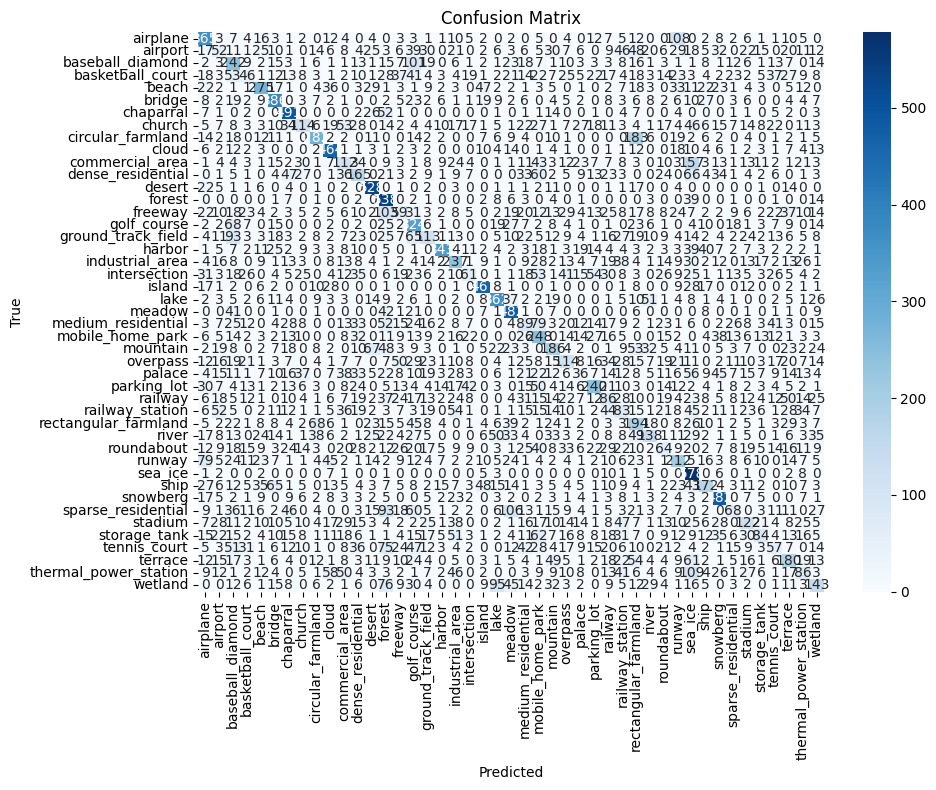

In [ ]:
from torchsummary import summary
import torch.optim as optim
import json
from datetime import datetime

# Check if CUDA is available and move the model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_path = "/content/drive/MyDrive/COMP 841/Models/ensemble-model.pth"

# Load the teacher and set it to eval mode
teacher_state = torch.load(teacher_path, map_location=device)
teacher = ensemble_model
teacher.to(device)
teacher.load_state_dict(teacher_state)

# tiny_student = NextViT(
#     stem_chs=[32, 32, 32],             # Small conv stem
#     depths=[2, 2, 4, 2],               # 10 total blocks
#     path_dropout=0.1,
#     keep_ratio=0.75,           # uniform pruning
#     head_dim=24,                       # fewer attention heads
#     mix_block_ratio=0.7,              # 70% MHSA / 30% MHCA in NTB
#     num_classes=num_classes,
#     use_checkpoint=False,
#     preserve_spatial_layout=False
# )

#Istatiate the Adaptive-NextViT as the student model
depths = [3, 4, 10, 3]
params = {
    'stem_chs': [64, 32, 64],
    'depths': depths,
    'path_dropout': 0.1,
    'num_classes': num_classes,
    'resolution': resolution,
    'batch_size': batch_size,
    'keep_ratios': 'CNN',
    # 'keep_ratios': generate_log_keep_ratios(sum(depths), min_keep=0.3),
    'train_split': train_split
}
student = create_model('efficientnet_b3', pretrained=False, num_classes=num_classes)

# student = NextViT(
#   stem_chs=params['stem_chs'],
#   depths= params['depths'],
#   path_dropout=params['path_dropout'],
#   # keep_ratios= generate_log_keep_ratios(sum(depths), min_keep=0.3),
#   keep_ratios=params['keep_ratios'],
#   num_classes=params['num_classes']
# )
student.to(device)
optimizer = optim.Adam(student.parameters(), lr=0.00005)

# Print the student model summary
summary(student, input_size=( 3, resolution, resolution))  # Adjust based on input image size

#Training loop
accuracies, lossess, train_accuracy, train_loss = train_knowledge_distillation(student, teacher, train_loader, optimizer, device, num_epochs=600, verbose=False)
print(f"Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
# Save the student model
student_path = "/content/drive/MyDrive/COMP 841/Models/student-model.pth"
torch.save(student.state_dict(), student_path)

# Evaluate the student model (Adaptive NextViT)
acc, avg_ms, std_ms, flops, cf_matrix = evaluate_model(student, test_loader, device, verbose=False)
print(f"Accuracy: {acc:.2f}%, Average Inference Time: {avg_ms:.4f} ms, Std Dev: {std_ms:.4f} ms, FLOPs: {flops:.4f}")
results = {
    'config': params,
    'accuracies': accuracies,
    'lossess': lossess,
    'train_accuracy': train_accuracy,
    'train_loss': train_loss,
    'accuracy': acc,
    'avg_ms': avg_ms,
    'std_ms': std_ms,
    'flops': flops
}
json.dump(results, open(f'/content/drive/MyDrive/COMP 841/Results/student-{datetime.now()}.json', 'w'), indent=4)
display_confusion_matrix(cf_matrix, class_names)

# Load results and plot them

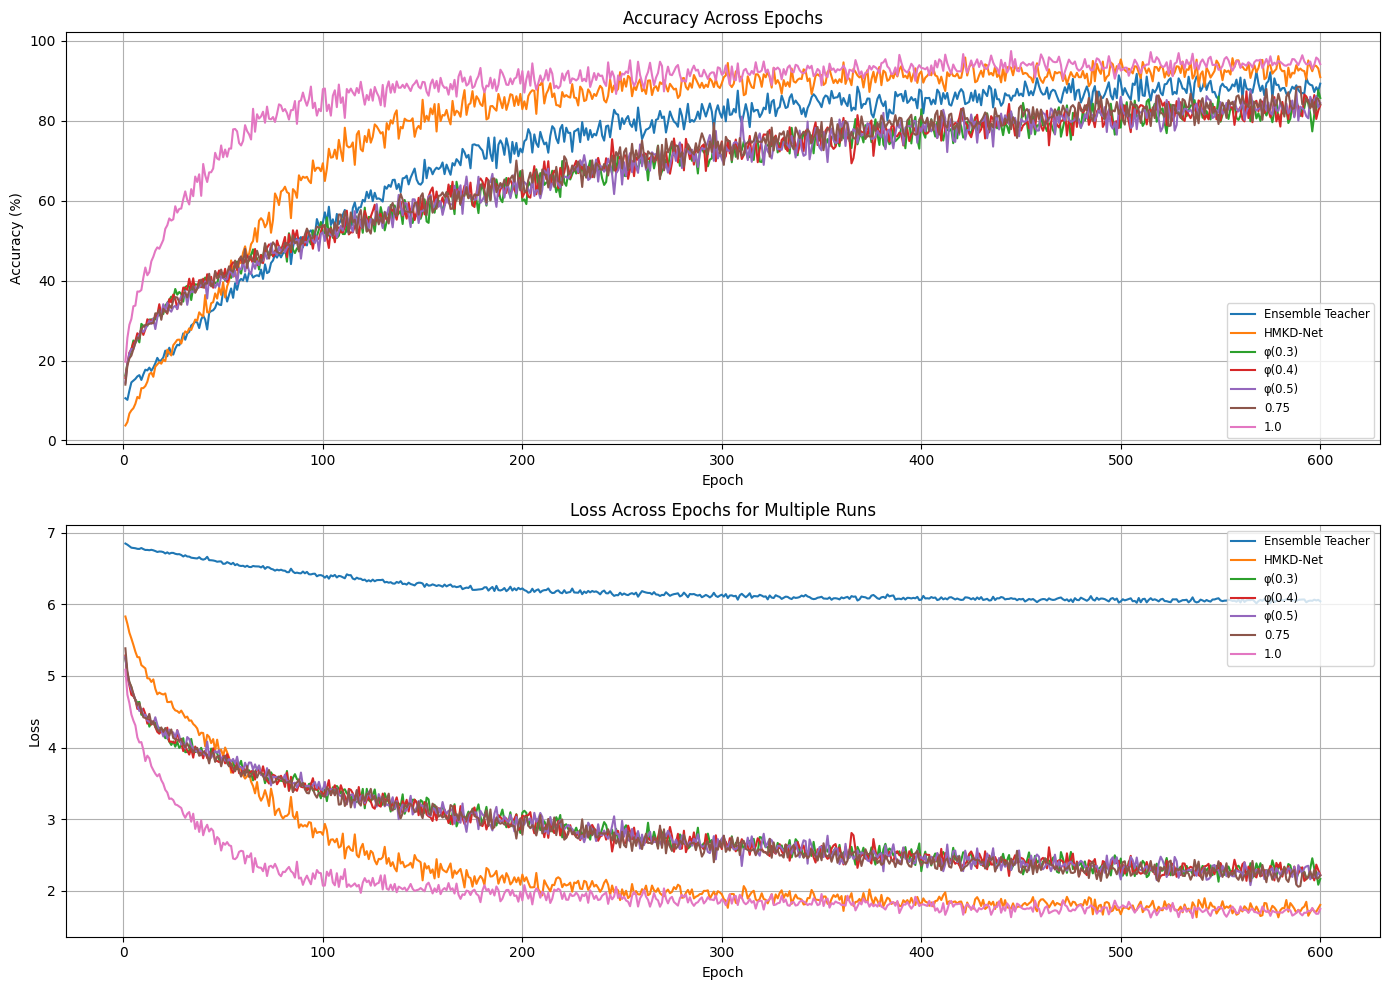

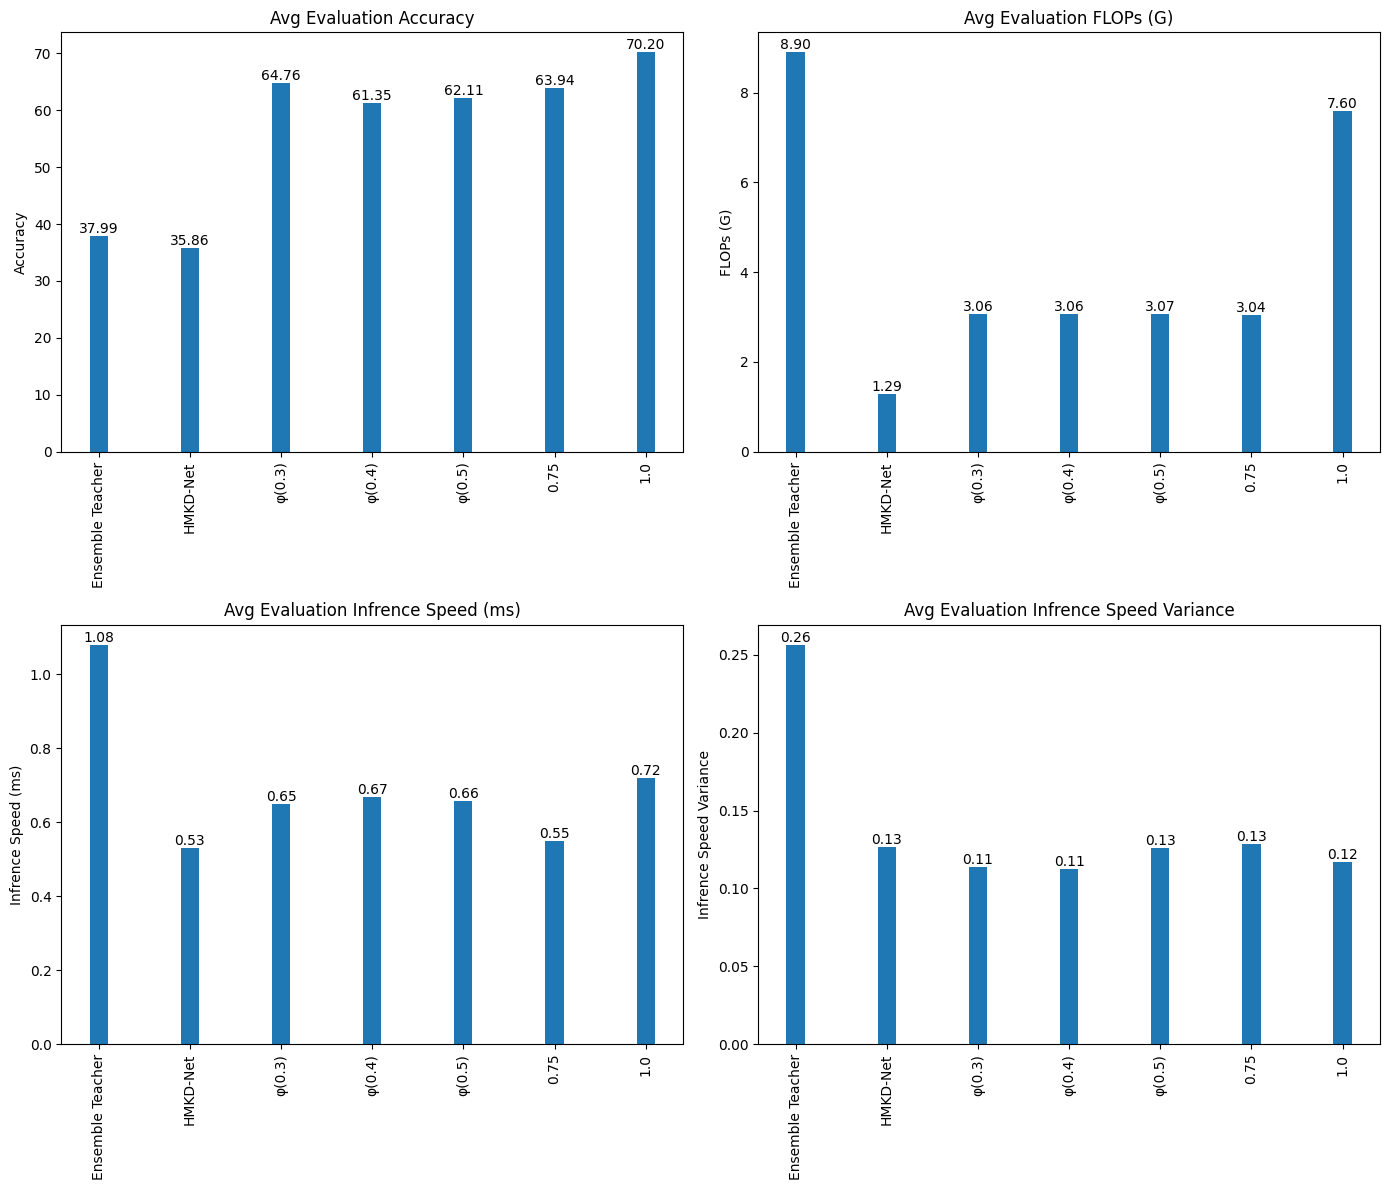

In [ ]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np

# Get all result files, sorted by name in reverse order
results = sorted(
    Path("/content/drive/MyDrive/COMP 841/Results").glob('*.json'),
    key=lambda p: p.name,
    reverse=True
)

metrics = {}

# Load data from each result file
for result in results:
    content = result.read_text()
    data = json.loads(content)
    keep_ratios = data.get('config', {}).get('keep_ratios')

    # Handle different cases of 'keep_ratios'
    if keep_ratios is None:
        continue
    elif isinstance(keep_ratios, list) and keep_ratios:  # non-empty list
        key = f'φ({keep_ratios[-1]:.1f})'
    else:
        key = f'{keep_ratios}'

    # Store metrics (accuracies, losses, and additional metrics)
    if key not in metrics:
        metrics[key] = {k: v for k, v in data.items() if k != 'config'}

# Create the first figure for accuracy and loss across epochs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

epochs = range(1, 600 + 1)
for label, metric in metrics.items():
    # Plot Accuracy on the top subplot (ax1)
    ax1.plot(epochs, metric.get('accuracies'), label=label)

    # Plot Loss on the bottom subplot (ax2)
    ax2.plot(epochs, metric.get('losses'), label=label)

# Plot settings for Accuracy subplot
ax1.set_title("Accuracy Across Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.grid(True)
ax1.legend(loc='lower right', fontsize='small')

# Plot settings for Loss subplot
ax2.set_title("Loss Across Epochs for Multiple Runs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend(loc='upper right', fontsize='small')

# Adjust layout for the first figure
plt.tight_layout()
plt.show()

# Create the second figure for the 4 metrics (Bar Graphs) in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns

# Define the 4 metrics you want to plot
metric_names = [('accuracy','Accuracy'), ('flops', 'FLOPs (G)'), ('avg_ms', 'Infrence Speed (ms)'), ('std_ms', 'Infrence Speed Variance')]

# x-axis positions for each bar
x_positions = np.arange(len(metrics))  # x-axis positions for each run
bar_width = 0.2  # Width of bars in the bar plot

# Loop through each metric and plot it on a separate subplot
for i, (metric_name, title) in enumerate(metric_names):
    # Determine the correct subplot position (row, column)
    row = i // 2  # Integer division to get row index
    col = i % 2   # Modulo to get column index

    # If the metric is 'flops', convert it to GFLOPS (1 GFLOP = 10^9 FLOPS)
    if metric_name == 'flops':
        metric_values = [metric.get(metric_name, 0) / 1e9 for metric in metrics.values()]  # Convert FLOPS to GFLOPS
    else:
        metric_values = [metric.get(metric_name, 0) for metric in metrics.values()]

    # Plot the bars for each metric in the respective subplot
    bars = axs[row, col].bar(x_positions, metric_values, bar_width, label=title)

    # Overlay the actual values on top of the bars
    for bar in bars:
        height = bar.get_height()
        axs[row, col].text(
            bar.get_x() + bar.get_width() / 2,  # x-position of the label
            height,  # y-position of the label
            f'{height:.2f}',  # Format the value to 2 decimal places
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment (place value on top of the bar)
            fontsize=10
        )

    # Set title and labels for each subplot
    axs[row, col].set_title(f"Avg Evaluation {title}")
    axs[row, col].set_ylabel(title)
    axs[row, col].set_xticks(x_positions)
    axs[row, col].set_xticklabels(metrics.keys(), rotation=90)

# Adjust layout for the second figure
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the student model (Adaptive NextViT)
acc, avg_ms, std_ms, flops, cf_matrix = evaluate_model(student, test_loader, device, verbose=False)
print(f"Accuracy: {acc:.2f}%, Average Inference Time: {avg_ms:.4f} ms, Std Dev: {std_ms:.4f} ms, FLOPs: {flops:.4f}")
json.dump(results, open(f'/content/drive/MyDrive/COMP 841/Results/student-{datetime.now()}.json', 'w'), indent=4)
display_confusion_matrix(cf_matrix, class_names)